## Homework

> Note: sometimes your answer doesn't match one of the options exactly. 
> That's fine. 
> Select the option that's closest to your solution.


### Dataset

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

Or you can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
```

We need to take `bank/bank-full.csv` file from the downloaded zip-file.  
In this dataset our desired target for classification task will be `y` variable - has the client subscribed a term deposit or not. 

### Features

For the rest of the homework, you'll need to use only these columns:

* `age`,
* `job`,
* `marital`,
* `education`,
* `balance`,
* `housing`,
* `contact`,
* `day`,
* `month`,
* `duration`,
* `campaign`,
* `pdays`,
* `previous`,
* `poutcome`,
* `y`

### Data preparation

* Select only the features from above.
* Check if the missing values are presented in the features.

**Answer:** no missing values in the columns of interest

In [1]:
import pandas as pd
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

pd.set_option('future.no_silent_downcasting', True)

In [2]:
s = """* `age`,
* `job`,
* `marital`,
* `education`,
* `balance`,
* `housing`,
* `contact`,
* `day`,
* `month`,
* `duration`,
* `campaign`,
* `pdays`,
* `previous`,
* `poutcome`,
* `y`"""

In [3]:
desired_columns = re.findall('`(.*?)`', s)

df = (
    pd.read_csv('/home/jeff/Downloads/zoomcamp_hw_3/bank-full.csv',sep=';')
    .loc[:,desired_columns]
)

df.isna().sum()


age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Question 1

What is the most frequent observation (mode) for the column `education`?

- `unknown`
- `primary`
- `secondary`
- `tertiary`

**Answer:** secondary

In [4]:
(
    df
    .loc[:,'education']
    .value_counts()
)

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

### Question 2

Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your dataset. 
In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

- `age` and `balance`
- `day` and `campaign`
- `day` and `pdays`
- `pdays` and `previous`


### Target encoding

* Now we want to encode the `y` variable.
* Let's replace the values `yes`/`no` with `1`/`0`.

### Split the data

* Split your data in train/val/test sets with 60%/20%/20% distribution.
* Use Scikit-Learn for that (the `train_test_split` function) and set the seed to `42`.
* Make sure that the target value `y` is not in your dataframe.

**Answer:** highest correlation is pdays and previous

In [5]:
(
    df
    .select_dtypes('number')
    .corr()
)

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


In [6]:
df = (
    df
    .replace({'y':{'yes':1, 'no':0}})
    .astype({'y':int})
)

In [7]:
def train_val_test_split(X, y, pct_splits, random_state):
    X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=pct_splits[-1], random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=pct_splits[1]/(sum(pct_splits[:2])), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
X = df.drop('y', axis=1)
y = df.loc[:,'y']
pct_splits = [0.6, 0.2, 0.2]

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, pct_splits, random_state=42)

### Question 3

* Calculate the mutual information score between `y` and other categorical variables in the dataset. Use the training set only.
* Round the scores to 2 decimals using `round(score, 2)`.

Which of these variables has the biggest mutual information score?
  
- `contact`
- `education`
- `housing`
- `poutcome`

**Answer:** largest score is poutcome

In [9]:
result_l = []

for col in ['contact', 'education','housing','poutcome']:
    result_l.append({'column':col,'score':mutual_info_score(df.loc[:,'y'],df.loc[:,col])})

df_result = (
    pd.DataFrame(result_l)
    .sort_values('score', ascending=False)
)

In [10]:
df_result

,column,score
3,poutcome,0.029397
0,contact,0.013627
2,housing,0.009654
1,education,0.002598


### Question 4

* Now let's train a logistic regression.
* Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

- 0.6
- 0.7
- 0.8
- 0.9

**Answer:** model accuracy is 0.90

In [11]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


In [12]:
model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(),['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']),
        remainder='passthrough',
        force_int_remainder_cols=False
    ),
    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'contact', 'month',
                                                   'poutcome'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

In [13]:
original_accuracy = accuracy_score(y_val, model.predict(X_val))
print(original_accuracy)

0.9009068790090687


### Question 5 

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 

Which of following feature has the smallest difference?

- `age`
- `balance`
- `marital`
- `previous`

> **Note**: The difference doesn't have to be positive.

**Answer:** removing age has the least effect, it does not change the model. So the difference is 0.00. By the way, this is what permutation importance measures!

In [14]:
feature_cols = (
    df
    .drop('y', axis=1)
    .columns
    .tolist()
)

result_l = []

for col in feature_cols:

    df_test = X_train.drop(col, axis=1)
    one_hot_columns = df_test.select_dtypes('object').columns
    
    model = make_pipeline(
        make_column_transformer(
            (OneHotEncoder(), one_hot_columns),
            remainder='passthrough',
            force_int_remainder_cols=False
        ),
        LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
    )

    model.fit(df_test, y_train)
    result_l.append({'feature_removed':col, 'accuracy':accuracy_score(y_val, model.predict(X_val.drop(col, axis=1)))})


df_result = (
    pd.DataFrame(result_l)
    .assign(
        delta = lambda x:(original_accuracy - x['accuracy']).abs()
    )
    .sort_values('delta')
)
            

In [15]:
df_result

,feature_removed,accuracy,delta
0,age,0.900907,0.000000
1,job,0.900907,0.000000
4,balance,0.900796,0.000111
2,marital,0.901017,0.000111
3,education,0.901017,0.000111
10,campaign,0.900686,0.000221
12,previous,0.901128,0.000221
11,pdays,0.901239,0.000332
6,contact,0.900464,0.000442
7,day,0.901349,0.000442


## this is pretty much *exactly* what permuation importance measures:

In [18]:
from sklearn.inspection import permutation_importance

model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(),['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']),
        remainder='passthrough',
        force_int_remainder_cols=False
    ),
    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
)

model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'contact', 'month',
                                                   'poutcome'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='liblinear'))])

<Axes: xlabel='feature'>

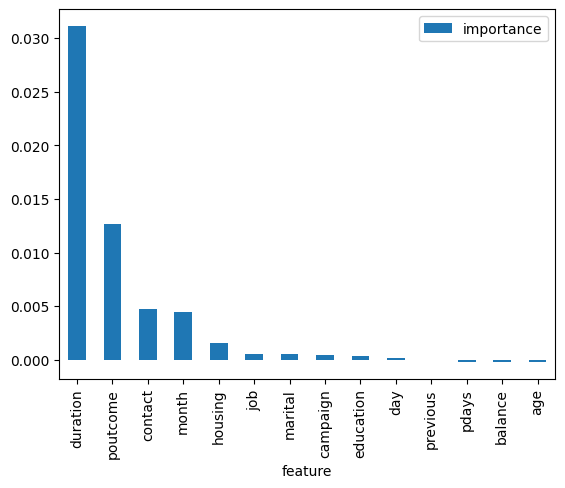

In [30]:
importances = permutation_importance(model, X_train, y_train)

(
    pd.DataFrame({'feature':model[:-1].feature_names_in_, 'importance':importances.importances_mean})
    .sort_values('importance', ascending=False)
    .plot(kind='bar', x='feature', y='importance')
)

### Question 6

* Now let's train a regularized logistic regression.
* Let's try the following values of the parameter `C`: `[0, 0.01, 0.1, 1, 10]`.
* Train models using all the features as in Q4.
* Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these `C` leads to the best accuracy on the validation set?

- 0.01
- 0.1
- 1
- 10
- 100

> **Note**: If there are multiple options, select the smallest `C`.

**Answer:** C=100 gives the best accuracy, but tbh there's not much overall difference between values of C. This is what grid search does also!

In [16]:
result_l = []

for C in  [0.01, 0.1, 1, 10, 100]:
    model = make_pipeline(
        make_column_transformer(
            (OneHotEncoder(),['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']),
            remainder='passthrough',
            force_int_remainder_cols=False
        ),
        LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    )

    model.fit(X_train, y_train)
    result_l.append({'C':C, 'accuracy':accuracy_score(y_val, model.predict(X_val))})

(
    pd.DataFrame(result_l)
    .sort_values('accuracy', ascending=False)
)

,C,accuracy
4,100.00,0.901349
3,10.00,0.901017
2,1.00,0.900907
1,0.10,0.900907
0,0.01,0.898142


## this is what grid search does.

Note that the grid search result is a little different, but pretty much directionally the same (larger C -> better accuracy)

In [35]:
from sklearn.model_selection import GridSearchCV

model = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(),['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']),
        remainder='passthrough',
        force_int_remainder_cols=False
    ),
    LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
)

parms = {'logisticregression__C':[0.01, 0.1, 1, 10, 100]}

model_gs = GridSearchCV(model, parms)

model_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'housing',
                                                                          'contact',
                                                                          'month',
                                                                          'poutcome'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [37]:
model_gs.best_params_

{'logisticregression__C': 10}

In [38]:
model_gs.cv_results_

{'mean_fit_time': array([0.10661807, 0.11694446, 0.12750573, 0.13590336, 0.13767033]),
 'std_fit_time': array([0.01187305, 0.01165726, 0.01579134, 0.02946662, 0.03238907]),
 'mean_score_time': array([0.00681419, 0.00676775, 0.00666332, 0.00668225, 0.00672336]),
 'std_score_time': array([1.93446753e-04, 1.82358078e-04, 5.97340134e-05, 6.81859796e-05,
        4.20983754e-05]),
 'param_logisticregression__C': masked_array(data=[0.01, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False],
        fill_value=1e+20),
 'params': [{'logisticregression__C': 0.01},
  {'logisticregression__C': 0.1},
  {'logisticregression__C': 1},
  {'logisticregression__C': 10},
  {'logisticregression__C': 100}],
 'split0_test_score': array([0.8982676 , 0.90084777, 0.90066347, 0.90140066, 0.90121637]),
 'split1_test_score': array([0.90341014, 0.90543779, 0.90617512, 0.90617512, 0.90599078]),
 'split2_test_score': array([0.89935484, 0.90101382, 0.90211982, 0.90211982, 0.90211982]),
 'spli

## Submit the results

* Submit your results here: https://courses.datatalks.club/ml-zoomcamp-2024/homework/hw03
* If your answer doesn't match options exactly, select the closest one